Packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from tqdm import tqdm
from matplotlib.pyplot import imshow, show
import math

Hyperparameters and shit

In [4]:
TIMESTEPS = 500
T_EMB_DIM = 256
T_EMB_DENOM = 10000

BATCH_SIZE = 128
NUM_EPOCHS = 100
COLORS = 1
IMG_SIZE = 32 #only working with square images
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transform definition

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*COLORS, [0.5]*COLORS),
])

Dataset

In [6]:
dataset = datasets.MNIST(root='./data', download = True, transform = transform)
loader = DataLoader(dataset, batch_size = BATCH_SIZE)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17710225.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 501285.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4554276.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 10133259.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Beta schedule and smth

In [7]:
beta = torch.linspace(1e-4,0.02,TIMESTEPS).to(DEVICE)
alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha,0)
forward_x0_coeff = torch.sqrt(alpha_cumprod)
forward_noise_coeff = torch.sqrt(1. - alpha_cumprod)
backward_brackets_coeff = torch.pow(alpha,-0.5)
backward_pred_noise_coeff = beta / torch.sqrt(1. - alpha_cumprod)

backward_std = torch.zeros(TIMESTEPS).to(DEVICE)
for i in range(1,TIMESTEPS):
    backward_std[i] = ((1. - alpha_cumprod[i-1])/(1. - alpha_cumprod[i]) * beta[i])**0.5

Defining forward process

In [8]:
def forward_process(x,t):
    noise = torch.randn_like(x).to(DEVICE)
    return forward_x0_coeff[t] * x\
     + forward_noise_coeff[t] * noise,\
     noise

Time embedding

In [9]:
t_emb = torch.zeros((TIMESTEPS,T_EMB_DIM)).to(DEVICE)
t = torch.arange(TIMESTEPS).to(DEVICE)
for i in range(T_EMB_DIM):
    if i%2 == 0:
        t_emb[:,i] = torch.sin(t * math.exp(-math.log(T_EMB_DENOM) * i / T_EMB_DIM))
    else:
        t_emb[:,i] = torch.cos(t * math.exp(-math.log(T_EMB_DENOM) * (i-1) / T_EMB_DIM))

Defining architecture

In [10]:
class ConvBlock(nn.Module):
    def __init__(self,inp,mid,out,tr):
        super().__init__()
        self.x_process = nn.Conv2d(inp,mid,3,1,1)
        self.time_process = nn.Sequential(
            nn.Linear(T_EMB_DIM,out),
            nn.LeakyReLU(0.15),
            nn.Linear(out,out),
            )
        self.conv = self.convolution(mid,out,tr)
        self.norm = nn.GroupNorm(min(8,out),out)
        self.activate = nn.LeakyReLU(0.15)

    def convolution(self,inp,out,tr):
        if tr:
            return nn.ConvTranspose2d(inp,out,4,2,1)
        else:
            return nn.Conv2d(inp,out,4,2,1)

    def forward(self,x,t):
        x = self.conv(self.activate(self.x_process(x)))
        t = self.time_process(t).unsqueeze(-1).unsqueeze(-1).expand(-1,-1,x.shape[2],x.shape[3])
        return self.activate(self.norm(x + t))

In [11]:
class Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_steps = math.floor(math.log(IMG_SIZE,2)) - 2
        self.down_steps = []
        self.up_steps = []
        bottle_dim = IMG_SIZE
        for i in range(self.n_steps):
            inp = 2 * 4**i
            mid = inp * 2
            out = mid * 2
            if i==0:
                inp = COLORS
            self.down_steps.append(
                ConvBlock(inp,mid,out,False)
            )
            if i + 1 != self.n_steps:
                self.up_steps.append(
                        ConvBlock(out * 2,mid,inp,True)
                    )
            else:
                self.up_steps.append(
                        ConvBlock(out,mid,inp,True)
                    )

            bottle_dim = bottle_dim//2
        self.down_steps = nn.ModuleList(self.down_steps)
        self.bottle = nn.Sequential(
            nn.Conv2d(out,out * 2,bottle_dim,4,0),
            nn.LeakyReLU(0.15),
        )
        self.time_injection = nn.Sequential(
            nn.Linear(T_EMB_DIM,out * 2),
            nn.LeakyReLU(0.15),
            nn.Linear(out * 2, out * 2),
        )
        self.middle = nn.Sequential(
            nn.Linear(out*2,out*2),
            nn.LeakyReLU(0.15),
            nn.Linear(out*2,out*2)
            )
        self.unbottle = nn.Sequential(
            nn.ConvTranspose2d(out*2,out,bottle_dim,4,0),
            nn.LeakyReLU(0.15),
            )
        self.up_steps = nn.ModuleList(self.up_steps)
        self.finale = nn.Sequential(
            nn.Conv2d(COLORS,COLORS,3,1,1),
            nn.LeakyReLU(0.15),
            nn.Conv2d(COLORS,COLORS,3,1,1),
        )

    def forward(self,x,t):
        skip_x = []
        t = t_emb[t]
        for i in range(self.n_steps):
            x = self.down_steps[i](x,t)
            skip_x.append(x)

        x = (self.bottle(x) + self.time_injection(t).unsqueeze(-1).unsqueeze(-1))
        x = self.unbottle(x)

        for i in range(self.n_steps)[::-1]:
            if i + 1 != self.n_steps:
                x = self.up_steps[i](torch.cat((x,skip_x[i]),dim = 1),t)
            else:
                x = self.up_steps[i](x,t)
        return self.finale(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

Training

In [12]:
model = Denoiser().to(DEVICE)
opt = optim.Adam(model.parameters(),lr = 3e-4)

In [13]:
crit = nn.MSELoss()

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx,(real,_) in enumerate(loader):
        real = real.to(DEVICE)
        t = torch.randint(low = 0,high = TIMESTEPS,size = (real.shape[0],)).to(DEVICE)
        noised = torch.zeros_like(real).to(DEVICE)
        noise = torch.zeros_like(real).to(DEVICE)
        for i in range(real.shape[0]):
            noised[i],noise[i] = forward_process(real[i],t[i])
        pred_noise = model(noised,t)
        loss = crit(pred_noise,noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

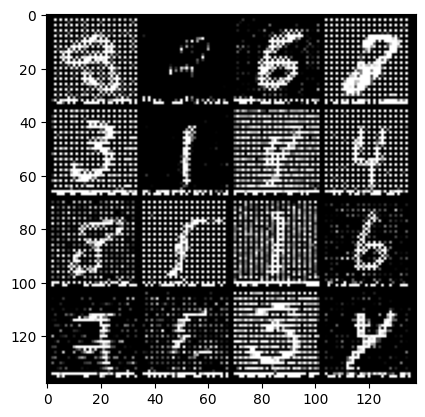

In [20]:
Size = 16
validation = torch.randn(Size,COLORS,IMG_SIZE,IMG_SIZE).to(DEVICE)
model.eval()
with torch.no_grad():
    validation_tmp = validation
    for i in range(TIMESTEPS)[::-1]:
        z = torch.randn_like(validation_tmp).to(DEVICE)
        t = i*torch.ones(Size).type(torch.int).to(DEVICE)
        pred_noise = model(validation_tmp,t)
        validation_tmp = backward_brackets_coeff[i] * (validation_tmp - backward_pred_noise_coeff[i] * pred_noise) \
            + backward_std[i] * z
    grid = make_grid(validation_tmp,nrow = Size//4).to("cpu")
    imshow(grid.permute(1,2,0))
    show()

obviously this isn't very good, but it does still produce quite readable symbols